<h1 align="center">
    Predicting the UEFA European Football Championship... and the Best Fantasy Assets
</h1>

<h1 style="font-size:12px" align="center">Tutorial by Aabid Roshan, Sid Joshi, Pranav Sivaraman</h1>

---

<h1 align="Center">
    Introduction
</h1>

<h1 style="font-size:18px">
    Tournament info
</h1>

<p style="font-size:16px">
    The UEFA European Football Championship, also known as the Euros, is a tournament held by UEFA every four years in which selection of European countries compete. There are also similar competitions for other continents such as the CONCACAF Gold Cup which is held for North American international teams. Although there are many different continental competitions, the Euros are by far the most popular because the majority of the worlds best players play for European teams. Although this competition is called the 2020 Euros, it is being held in 2021 because of COVID. Currently the qualifiers for the tournment have already been played and the 24 teams that go into the tournament have already been decided. Later on you will see a list of these teams. The current reigning champions are Portugal.
</p>

<p style="font-size:16px">
    The format of the tournament starts off with a group stage where there are 6 groups of 4 teams each. During the group stage each team will play every other team twice, once at home and once away from home. Each team gets 3 points for a win, 1 for a draw, and 0 for a loss. At the end of the group stage, the top 2 teams move on to the next round and play in a standard knockout style tournament.
</p>

<h1 style="font-size:18px">
    Why do we want to predict the winner?
</h1>

<p style="font-size:16px">
    This is a pretty easy question to answer. Like with many other popular tournaments there are many uses for predicting the winner from something a trivial as bragging rights all the way to deciding which team to bet on to win the whole thing.
</p>

<h1 style="font-size:18px">
    Libraries Used
</h1>

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from datetime import date

<h1 align="center">
    Data Scraping/Management
</h1>
<p style="font-size:16px">
    Our data source is hosted on Kaggle which can be found <a href="https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017">here</a>. Despite the dataset title having a stopping a year, the dataset is still regulary updated with international matches. The data was created by Mart Jürisoo so extra thanks to him.
</p>

<h1 style="font-size:20px">
    Loading the Data
</h1>
<p style="font-size:16px">
    To extract the data from the file we use the pandas
        <a href="https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html">read_csv</a> function and put the data into a dataframe. After extracting the data we want to convert the data column into a datetime object so it can be used to make things more convenient later on. This can be done by using the pandas <a href="https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html">to_datetime</a> function.
</p>

In [3]:
df = pd.read_csv("results.csv")
df['date'] = pd.to_datetime(df['date'])
df.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


<p style="font-size:16px">
    This is the data we will be using going forward. Below is a list of what each column represents.
    <ol>
        <li><b>date:</b> The date of the match</li>
        <li><b>home_team:</b> The home team</li>
        <li><b>away_team:</b> The away team</li>
        <li><b>home_score:</b> The number of goals scored by the home team</li>
        <li><b>away_score:</b> The number of goals scored by the away team</li>
        <li><b>tournament:</b> This is the name of the competition the match was played in. This could range anywhere from a simple friendly to a World Cup Final game. There are many different competitions around the world</li>
        <li><b>city:</b> The city the game was played in</li>
        <li><b>country:</b> The country the game was played in</li>
        <li><b>neutral:</b> This is whether or not the game was played at a neutral stadium. A neutral stadium is when neither team is home nor away. Both teams must travel to a stadium that is not their own</li>
    </ol>
</p>

<p style="font-size:16px">
    The data in its current format is very hard to analyze. We cannot immediately plot any of the data to visualize any relationships between variables. Therefore, some sort of data analysis needs to be done in order to come to any conclusions about the data. Our data analysis approach would be to rank the teams based on the match results and then predict future outcomes. But before we can start ranking teams, we need to test one parameter and its effects on the match results.
</p>




---

<h1 align="center">
    Hypothesis Testing
</h1>

<h1 style="font-size:18px">
    Hypothesis test intro
</h1>

<p style="font-size:16px">
    Now we move on to the hypothesis testing part. A hypothesis test is a good way of testing whether or not the change in one variable has a significant effect on another variable. We would want to declare a null hypothesis and an alternative hypothesis and see whether or not we should reject the null hypothesis.
</p>

<p style="font-size:16px">
    In this scenario we want to see whether or not having a home advantage effects your chances of winning a game. Depending on the outcome we can then decide whether or not to factor home team advantage into our elo calculations.
</p>

<p style="font-size:16px">
    Listed below are our significance level, null hypothesis, and alternative hypothesis
</p>

\begin{equation}
\alpha = 0.05
\end{equation}
\begin{equation}
H_{0} = \textrm{There is no correlation between home advantage and win rate (home win rate = 50%)}
\end{equation}
\begin{equation}
H_{a} = \textrm{There is a correlation between home advantage and win rate (home win rate ≠ 50%)}
\end{equation}

<h1 style="font-size:18px">
    Prepping the data for the hypothesis test
</h1>

<p style="font-size:16px">
    First we want to remove all matches played on a neutral venue as there is no home or away advantage in this situation. We also want to add another column that consists of whether or not the home team won that game. 1 meaning the home team won, 0 meaning the home team drew or lost.
</p>

In [4]:
nonneutral = df.copy()[df['neutral'] == False]
nonneutral['home_win'] = [1 if row['home_score'] > row['away_score'] else 0 for index, row in nonneutral.iterrows()]
nonneutral.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_win
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1


<h1 style="font-size:18px">
    Finding the p-value
</h1>

<p style="font-size:16px">
    Next using the scipy.stats library, we can run a one sample t-test to get the p-value. We want to run the test against a mean of 0.5 because that would correlate to a 50% win rate for the home side. If said p-value is less than our level of significance we reject the null hypothesis, otherwise we accept it.
</p>

In [5]:
tset, pval = ttest_1samp(nonneutral['home_win'], 0.5)
print("p-value",pval)

p-value 0.1324237757412294


<p style="font-size:16px">
    Since our p-value of 0.132 is greater than the level of significance, we accept the null hypothesis. This means that there is no correlation between home advantage and win rate.
</p>



<h1 align="center">
    Exploratory Data Analysis
</h1>

<p style="font-size:16px">
    
</p>

<h1 align="left">
    The ELO Rating System
</h1>

<p style="font-size:16px">
    The ranking system we decided on using was the ELO rating system that is used to calculate the relative skill of players based on match results. The ELO rating system is famous for its implementation in chess and slowly has been adopted as a rating system for various sports leagues such as the NFL, NBA, and FIFA.
</p>

<h1 style="font-size:18px">
    Creating the Ranking System
</h1>

<p style="font-size:16px">
    In order to create a rating system we first neeed to establish the 'players' that are participating in the games. Since we are trying to predict the 2020 Euros. Our list of players would be the 24 countries participating in the tournament. However, our rating system is able to support a much larger list of countries. The countries playing in the 2020 Euros can be found <a href="https://www.uefa.com/uefaeuro-2020/news/0256-0db422ecc788-fc419fd78f92-1000--euro-2020-meet-the-teams/">here</a>.
</p>

In [6]:
teams = ['Turkey', 'Italy', 'Wales', 'Switzerland',
         'Denmark', 'Finland', 'Belgium', 'Russia',
         'Netherlands', 'Ukraine', 'Austria', 'North Macedonia',
         'England', 'Croatia', 'Scotland', 'Czech Republic',
         'Spain', 'Sweden', 'Poland', 'Slovakia',
         'Hungary', 'Portugal', 'France', 'Germany']

<p style="font-size:16px">
    With the countries selected we can now register them into our ranking system. Each country is registered with the same initial rating along with a corresponding start date. Both the intial rating and the start date parameters can be adjusted.
</p>

In [7]:
def initialize_elo_system(teams, initial_rating, start_year):
    ratings = {}
    for team in teams:
        start_date = np.datetime64(f'{start_year}-01', 'D')
        ratings[team] = [initial_rating], [start_date]
        
    return ratings

<p style="font-size:16px">
    In order to update the rating after every match, we need to calculate the probability of each team winning the match. The following two formulas allows us to do so. Since a non-neutral stadium does not have an effect on the results of the match according to our hypothesis test, we will not be using it in order to calculate the probability of winning a match.
</p>

\begin{equation}
E_a = \frac{1}{1 + 10^{(R_b-R_a)/\text{scale factor}}}
\end{equation}
\begin{equation}
E_b = \frac{1}{1 + 10^{(R_a-R_b)/\text{scale factor}}}
\end{equation}

<p style="font-size:16px">
    R refers to the current rating of each player. The rating difference is then divided by a scale factor
</p>

In [8]:
def calculate_probabilities(home_rating, away_rating, scale_factor=400):
    p_home = 1 / (1 + 10**((away_rating - home_rating) / scale_factor))
    p_away = 1 / (1 + 10**((home_rating - away_rating) / scale_factor)) 
    
    return p_home, p_away

<p style="font-size:16px">
    Once we have calculated the ratings we need to update the ratings for each team after the match is played out. We using the following formula to update the rating.
</p>

<p style="font-size:16px">
    S refers to the score the player receives after a match, with wins, losses, and draws being represented as 
1, 0, and 0.5 respectively. The difference between the score and the probability is then multiplied by a k-factor which helps adjust over and under performness. 
</p>

<p style="font-size:16px">
    With each update to the rating we also keep track of the date when it was updated, in this case the day of the match. This will become very useful when we are plotting the ELOs of all the teams over time.
</p>

In [9]:
def calculate_ratings(matches, ratings, k_factor=22.2):
    num_matches = len(matches)
    home_teams, away_teams = matches['home_team'].values, matches['away_team'].values
    home_scores, away_scores = matches['home_score'].values, matches['away_score'].values
    match_dates = matches['date'].values
    
    for i in range(num_matches):
        home_team, away_team = home_teams[i], away_teams[i]
        home_score, away_score = home_scores[i], away_scores[i]
        match_date = match_dates[i]
                
        p_home, p_away = calculate_probabilities(ratings[home_team][0][-1], ratings[away_team][0][-1])
        
        if home_score > away_score:
            match_result_home = 1
            match_result_away = 0
        elif home_score < away_score:
            match_result_home = 0
            match_result_away = 1
        elif home_score == away_score:
            match_result_home = 0.5
            match_result_away = 0.5
            
        new_rating_home = ratings[home_team][0][-1] + k_factor * (match_result_home - p_home)
        new_rating_away = ratings[away_team][0][-1] + k_factor * (match_result_away - p_away)
        
        ratings[home_team][0].append(new_rating_home)
        ratings[away_team][0].append(new_rating_away)
        
        ratings[home_team][1].append(match_date)
        ratings[away_team][1].append(match_date)
        
    return ratings

<p style="font-size:16px">
    Currently, our ratings are being stored in a dictionary with each country's values being their rating after a certain match. Since ELO updates only occur when matches are played, our current data format does not allow us to check a team's ELO rating at a specific date. 
</p>

<p style="font-size:16px">
    To allow that we will convert our dictionary values to a dataframe using the dates as indices and their entries being the rating at the time. After that we reindex our data frame with the date range with the start year used to intialize the elo system and the current day. While reindexing we pad all the days with the last valid input so that there is no missing data.
</p>


In [10]:
def convert_to_df(ratings, start_year):
    today = date.today()
    date_range = pd.date_range(start=f'1/1/{start_year}', end=today.strftime("%m/%d/%Y"))
    
    for country in ratings:
        df = pd.DataFrame(ratings[country][0], ratings[country][1], columns=[country])
        df = df.reindex(date_range, method='pad')
        ratings[country] = df
        
    ratings = pd.concat(list(ratings.values()), axis=1)
    
    return ratings

<p style="font-size:16px">
    Here we put all our previous functions together to finally create our rating system. The matches we use to calculate the ratings of all the countries fall in an adjustable date range. In addition we have to ensure that the teams of each match are part of the rating system. The final output is a large dataframe with every country's ELO rating at a certain date. 
</p>

In [11]:
# Putting it all together
def calculate_elo(teams, year_range, initial_rating=1200):
    ratings = initialize_elo_system(teams, initial_rating, year_range[0])
    matches = df[df['home_team'].isin(teams) & df['away_team'].isin(teams)]
    matches = matches[matches['date'].dt.year.between(year_range[0], year_range[1])]
    new_ratings = calculate_ratings(matches, ratings)
    new_ratings = convert_to_df(new_ratings, year_range[0])
    
    return new_ratings

In [14]:
ratings = calculate_elo(teams, [2016, 2021])
ratings.tail(5)

,Turkey,Italy,Wales,Switzerland,Denmark,Finland,Belgium,Russia,Netherlands,Ukraine,...,Scotland,Czech Republic,Spain,Sweden,Poland,Slovakia,Hungary,Portugal,France,Germany
2021-05-13,1196.273074,1254.448447,1177.399075,1173.110044,1231.70115,1106.916065,1287.233401,1145.970015,1232.520685,1193.182746,...,1156.143746,1147.720107,1269.474788,1159.941754,1186.766548,1143.136559,1137.088574,1288.365264,1313.192479,1233.496887
2021-05-14,1196.273074,1254.448447,1177.399075,1173.110044,1231.70115,1106.916065,1287.233401,1145.970015,1232.520685,1193.182746,...,1156.143746,1147.720107,1269.474788,1159.941754,1186.766548,1143.136559,1137.088574,1288.365264,1313.192479,1233.496887
2021-05-15,1196.273074,1254.448447,1177.399075,1173.110044,1231.70115,1106.916065,1287.233401,1145.970015,1232.520685,1193.182746,...,1156.143746,1147.720107,1269.474788,1159.941754,1186.766548,1143.136559,1137.088574,1288.365264,1313.192479,1233.496887
2021-05-16,1196.273074,1254.448447,1177.399075,1173.110044,1231.70115,1106.916065,1287.233401,1145.970015,1232.520685,1193.182746,...,1156.143746,1147.720107,1269.474788,1159.941754,1186.766548,1143.136559,1137.088574,1288.365264,1313.192479,1233.496887
2021-05-17,1196.273074,1254.448447,1177.399075,1173.110044,1231.70115,1106.916065,1287.233401,1145.970015,1232.520685,1193.182746,...,1156.143746,1147.720107,1269.474788,1159.941754,1186.766548,1143.136559,1137.088574,1288.365264,1313.192479,1233.496887


<p style="font-size:16px">
    We then calculate the rankings of each team based on the latest ELO rating each team has. The matches we used to calculate each team's ELO is from 2016-current, because international teams tend to change drastically each year.
</p>

In [16]:
rankings = ratings.iloc[-1,:].sort_values(ascending=False)
rankings

France             1313.192479
Portugal           1288.365264
Belgium            1287.233401
Spain              1269.474788
Italy              1254.448447
England            1233.501483
Germany            1233.496887
Netherlands        1232.520685
Denmark            1231.701150
Croatia            1204.113028
Turkey             1196.273074
Ukraine            1193.182746
Poland             1186.766548
Austria            1182.467219
Wales              1177.399075
Switzerland        1173.110044
Sweden             1159.941754
Scotland           1156.143746
Czech Republic     1147.720107
Russia             1145.970015
North Macedonia    1145.836863
Slovakia           1143.136559
Hungary            1137.088574
Finland            1106.916065
Name: 2021-05-17 00:00:00, dtype: float64

In [20]:
def plot_elos(ratings):
    plt.figure(figsize=(15, 10))
    
    for country in teams:
        plt.title('ELO Ratings of Qualified Euros Teams from 2016-Current')
        plt.ylabel('Rating')
        plt.xlabel('Year')
        dates, elos = ratings.index.values, ratings[country].values
        plt.plot(dates, elos, label=country)
        legend = plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='medium')

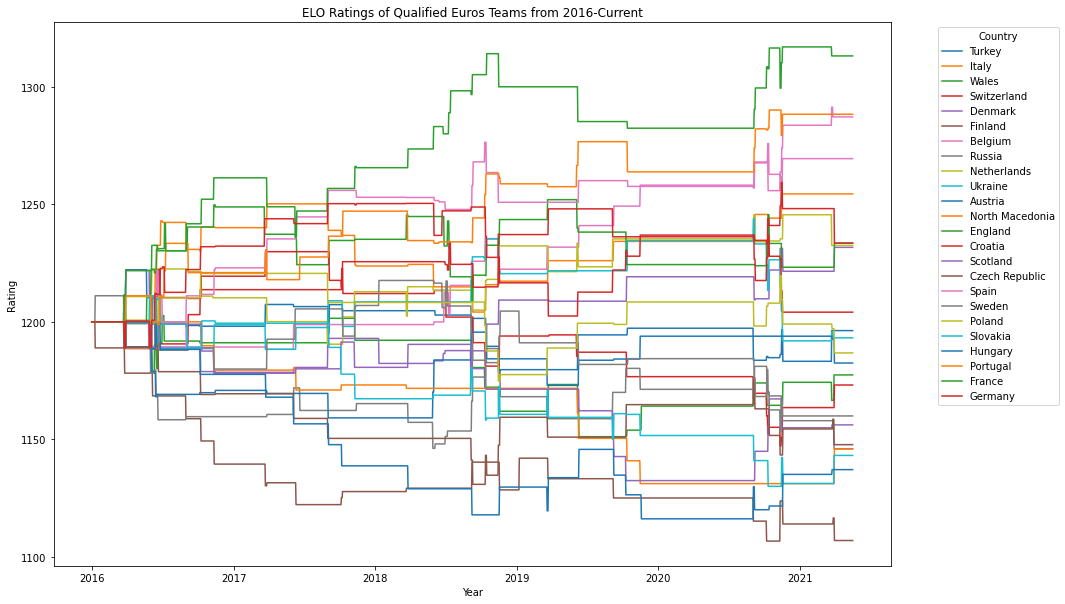

In [21]:
plot_elos(ratings)

---

<h1 align="center">
    Simulation
</h1>

<h1 style="font-size:18px">
    Predicting the Group Stage
</h1>

<p style="font-size:16px">
    These are what each group looks like after the draw by UEFA
</p>

<table style="width:100%">
  <tr>
    <th style="text-align:center">Group A</th>
    <th style="text-align:center">Group B</th> 
    <th style="text-align:center">Group C</th>
    <th style="text-align:center">Group D</th>
    <th style="text-align:center">Group E</th> 
    <th style="text-align:center">Group F</th>
  </tr>
  <tr>
    <td style="text-align:center">Italy</td>
    <td style="text-align:center">Belgium</td> 
    <td style="text-align:center">Austria</td>
    <td style="text-align:center">Croatia</td>
    <td style="text-align:center">Poland</td> 
    <td style="text-align:center">France</td>
  </tr>
  <tr>
    <td style="text-align:center">Switzerland</td>
    <td style="text-align:center">Denmark</td> 
    <td style="text-align:center">Netherlands</td>
    <td style="text-align:center">Czech Republic</td>
    <td style="text-align:center">Slovakia</td> 
    <td style="text-align:center">Germany</td>
  </tr>
  <tr>
    <td style="text-align:center">Turkey</td>
    <td style="text-align:center">Finland</td> 
    <td style="text-align:center">North Macedonia</td>
    <td style="text-align:center">England</td>
    <td style="text-align:center">Spain</td> 
    <td style="text-align:center">Hungary</td>
  </tr>
  <tr>
    <td style="text-align:center">Wales</td>
    <td style="text-align:center">Russia</td> 
    <td style="text-align:center">Ukraine</td>
    <td style="text-align:center">Scotland</td>
    <td style="text-align:center">Sweden</td> 
    <td style="text-align:center">Portugal</td>
  </tr>
</table>

In [43]:
def calculate_group_stage(group_rankings, group_length=4):
    outcomes = np.ones(4096)
    points = np.zeros((4096, 4))
    fixtures_prob = np.empty((6,2), dtype=object)
    fixtures = np.empty((6,2), dtype=object)
    qualify_prob = np.zeros(4)
    
    # create fixture matrix and fixture probabilities
    count = 1
    for i, j in zip(fixtures_prob, fixtures):
        i[0] = calculate_probabilities(group_rankings[0], group_rankings[count])
        j[0] = (0, count)
        if count == 3:
            i[1] = calculate_probabilities(group_rankings[1], group_rankings[2])
            j[1] = (1, 2)
            count = 1
        else:
            i[1] = calculate_probabilities(group_rankings[3-count], group_rankings[3])
            j[1] = (3-count, 3)
            count+=1
    
    
    # Loop through all combinations
    width = 1024
    low = 0
    high = 1024
    for i in range(0, len(fixtures_prob)):
        
        t = 1
        for sub in range(0, int(4096/width)):
            if t == 1:
                outcomes[low:high] *= fixtures_prob[i][0][0] * fixtures_prob[i][1][0]
                points[low:high][:, fixtures[i][0][0]] += 3
                points[low:high][:, fixtures[i][1][0]] += 3
            elif t == 2:
                outcomes[low:high] *= fixtures_prob[i][0][0] * fixtures_prob[i][1][1]
                points[low:high][:, fixtures[i][0][0]] += 3
                points[low:high][:, fixtures[i][1][1]] += 3
            elif t == 3:
                outcomes[low:high] *= fixtures_prob[i][0][1] * fixtures_prob[i][1][0]
                points[low:high][:, fixtures[i][0][1]] += 3
                points[low:high][:, fixtures[i][1][0]] += 3
            elif t == 4:
                outcomes[low:high] *= fixtures_prob[i][0][1] * fixtures_prob[i][1][1]
                points[low:high][:, fixtures[i][0][1]] += 3
                points[low:high][:, fixtures[i][1][1]] += 3
                t = 0
                
            t+=1
            
            low += int(width)
            high += int(width)
        
        width /= 4
        low = 0
        high = int(width)
        
    
    for index in range(0, len(points)):
        qualifiers = np.argpartition(points[index], -2)[-2:]
        qualify_prob[qualifiers] += outcomes[index]
    
    qualified = [(x, y) for y, x in sorted(zip(qualify_prob, group_rankings.index), reverse=True)]
    
    return qualified

In [45]:
group_stage_results = np.empty((6,4), dtype=object)
group_stage_results[0] = calculate_group_stage(rankings.loc[['Italy', 'Switzerland', 'Turkey', 'Wales']])
group_stage_results[1] = calculate_group_stage(rankings.loc[['Belgium', 'Denmark', 'Finland', 'Russia']])
group_stage_results[2] = calculate_group_stage(rankings.loc[['Austria', 'Netherlands', 'North Macedonia', 'Ukraine']])
group_stage_results[3] = calculate_group_stage(rankings.loc[['Croatia', 'Czech Republic', 'England', 'Scotland']])
group_stage_results[4] = calculate_group_stage(rankings.loc[['Poland', 'Slovakia', 'Spain', 'Sweden']])
group_stage_results[5] = calculate_group_stage(rankings.loc[['France', 'Germany', 'Hungary', 'Portugal']])

letter = 65
for elem in group_stage_results:
    print("Group " + chr(letter) + " results: ")
    print(elem)
    print("\n")
    letter += 1

Group A results: 
[('Italy', 0.6655358075238537) ('Wales', 0.5395250764518505)
 ('Turkey', 0.5053035413930346) ('Switzerland', 0.28963557463126194)]


Group B results: 
[('Belgium', 0.7923306036939437) ('Denmark', 0.5373357374970003)
 ('Russia', 0.4389066725330631) ('Finland', 0.231426986275995)]


Group C results: 
[('Ukraine', 0.6373190375875124) ('Netherlands', 0.5385378693020053)
 ('Austria', 0.4644214409254434) ('North Macedonia', 0.3597216521850499)]


Group D results: 
[('England', 0.6852479213280521) ('Croatia', 0.5451869840810164)
 ('Scotland', 0.5137511932076589) ('Czech Republic', 0.2558139013832696)]


Group E results: 
[('Spain', 0.7783878860228152) ('Sweden', 0.5151560979231617)
 ('Poland', 0.4701126767862071) ('Slovakia', 0.23634333926781947)]


Group F results: 
[('Portugal', 0.7545242720672843) ('France', 0.7182871631700508)
 ('Germany', 0.33547591562427026) ('Hungary', 0.19171264913839434)]




<p style="font-size:16px">
    These are our results from the simulation. From the group stage results, the top two teams from each group move on to the knockout stages. The final four teams are decided upon the top four 3rd place teams. In this case those teams would be Scotland, Turkey, Poland, and Austria. The bracket would look something like shown below. The bracket would be made as follows:
    <ol>
        <li>Match 1: Runners-up Group A vs Runners-up Group C</li>
        <li>Match 2: Winners Group D vs 3rd Place Group B/E/F</li>
        <li>Match 3: Winners Group B vs 3rd Place Group A/C/D</li>
        <li>Match 4: Winners Group F vs Runners-up Group E</li>
        <li>Match 5: Winners Group C vs 3rd Place Group A/B/F</li>
        <li>Match 6: Winners Group E vs Runners-up Group D</li>
        <li>Match 7: Winners Group A vs 3rd Place Group C/D/E</li>
        <li>Match 8: Runners-up Group B vs Runners-up Group F</li>
    </ol>
    information from <a href="https://en.wikipedia.org/wiki/UEFA_Euro_2016_knockout_phase">here</a>
</p>

<img src="Euros2020ro16.jpg" alt="Bracket">

<h1 style="font-size:18px">
    Showtime!
</h1>

<p style="font-size:16px">
    We will run a simulation based on the head to head properties. We will only roll once to decide which team wins the match. Without further ado, lets begin the Round of 16!
</p>

In [68]:
def find_winners(matches):
    winners = []
    count = 1
    for match in matches:
        elo1 = rankings[match[0]]
        elo2 = rankings[match[1]]
        print("Match " + str(count) + ":\t" + match[0] + " vs. " + match[1])
        winner = random.choices(match, calculate_probabilities(elo1, elo2))[0]
        winners.append(winner)
        print(winner + " Wins!")
        print("*********************")
        count += 1
       
    return winners

In [69]:
matches = [["Belgium", "Scotland"], ["Italy", "Netherlands"], ["Portugal", "Turkey"], ["Croatia", "Sweden"], ["Spain", "Austria"], ["England", "France"], ["Ukraine", "Poland"], ["Wales", "Denmark"]]
winners = find_winners(matches)

Match 1:	Belgium vs. Scotland
Scotland Wins!
*********************
Match 2:	Italy vs. Netherlands
Italy Wins!
*********************
Match 3:	Portugal vs. Turkey
Portugal Wins!
*********************
Match 4:	Croatia vs. Sweden
Sweden Wins!
*********************
Match 5:	Spain vs. Austria
Spain Wins!
*********************
Match 6:	England vs. France
France Wins!
*********************
Match 7:	Ukraine vs. Poland
Poland Wins!
*********************
Match 8:	Wales vs. Denmark
Denmark Wins!
*********************


<p style="font-size:16px">
    With these results, the bracket will now look like this. <b>Note: The scores say 1-0 but we didn't actually calculate the scores. We just needed to enter scores for the website the bracket was made on to work so we defaulted to 1-0.</b>
</p>

<img src="Euros2020qf.jpg" alt="Bracket">

<p style="font-size:16px">
    Now for the quarter-finals!
</p>

In [71]:
matches = [["Scotland", "Italy"], ["Portugal", "Sweden"], ["Spain", "France"], ["Poland", "Denmark"]]
winners = find_winners(matches)

Match 1:	Scotland vs. Italy
Italy Wins!
*********************
Match 2:	Portugal vs. Sweden
Portugal Wins!
*********************
Match 3:	Spain vs. France
Spain Wins!
*********************
Match 4:	Poland vs. Denmark
Denmark Wins!
*********************


<img src="Euros2020sf.jpg" alt="Bracket">

<p style="font-size:16px">
    Next up, Semi finals!
</p>

In [72]:
matches = [["Italy", "Portugal"], ["Spain", "Denmark"]]
winners = find_winners(matches)

Match 1:	Italy vs. Portugal
Portugal Wins!
*********************
Match 2:	Spain vs. Denmark
Denmark Wins!
*********************


<img src="Euros2020f.jpg" alt="Bracket">

<p style="font-size:16px">
    And finally, the Finals!
</p>

In [80]:
matches = [["Portugal", "Denmark"]]
winners = find_winners(matches)

Match 1:	Portugal vs. Denmark
Portugal Wins!
*********************


<p style="font-size:18px">
    <b>And Portugal reign victorius!</b>
</p>

<img src="Euros2020final.jpg" alt="Bracket">

---

<h1 align="center">
    Bonus Section: The Search For Fantasy Gold
</h1>

<h1 style="font-size:18px">
    Introduction
</h1>

<p style="font-size:16px">
Some believe that there is no sports without fantasy. This community is just as crazy and prevalent in the world of football. Whether it's Premier League Fantasy, UEFA Champions League Fantasy, or World Cup Fantasy, football fantasy fans are all in. That's why this data science guide to the Euros would not be complete if we didn't dedicate a section just for fantasy. Before the fantasy fans get too eager, let's get started...
</p>

<h1 style="font-size:18px">
    Preliminaries
</h1>

<p style="font-size:16px">
So first things first, if you are new to the realm of fantasy football don't worry. Here's the basics of how fantasy works... in most fantasy football formats (yes there are multiple fantasy games for the same sporting event, as you could imagine one simply wouldn't be enough for the fantasy community) you are given a certain amount of budget at the start of the season to build your squad. Using that budget, you pick a set of 15 or so players (a starting 11 plus bench players) from the entire selection of players available. Each player in the game is given a particular price tag, with the "better"/more high profile players costing more than other players. Once you have picked your initial team, you pick a starting 11 for each matchweek/gameweek, during which the players in your 11 rack up points based on how will they perform (in real life) during that week. Points are usually awarded for every goal scored, every assist, clean sheets, minutes played, saves (for goalkeepers), etc. Come the end of the season, the more total points you accumulate the higher up you are in the leaderboard (whether that's worldwide, or simply a mini league you and your colleagues at work/school started). Note that there are more involved aspects of fantasy such as weekly transfers, captaincy, chips like wildcard and benchboost, etc. but we are not going to dive into these aspects as they are not necessary to get you started (and in fact, have no effect on the area of focus for this guide, which will be the initial team selection).
</p>

<h1 style="font-size:18px">
    Euro Fantasy
</h1>

<p style="font-size:16px">
Okay, so now that you know the basics of fantasy, let's talk about how it relates to the Euros! As you might imagine, just as there are fantasy games for the annual football leagues played across the world (like the English Premier League, the German Bundesliga, the Italian Serie A, etc.), there are also fantasy games for singular tournaments such as the World Cup and the Euros, which take place every four years (Here's the official fantasy game sponsored by UEFA, you can started creating your team from <a href="https://gaming.uefa.com/en/uefaeuro2020fantasyfootball/create-team">here</a>). Since the tournament duration is only a month or two, the fantasy game will only run for the duration of the tournament. In fantasy games involving international tournaments, the game is usually split into two phases. One phase for the group stages and one phase for the knockout rounds. In other words, you get to choose an initial team to play during the group stage portion of the tournament (where each team is guaranteed to play 3 games against the other teams in their group), and then get to select a completely new squad for the knockout rounds, choosing players from the teams that are still alive in the tournament. 
</p>

<h1 style="font-size:18px">
    Our Approach
</h1>

<p style="font-size:16px">
In this guide, we will solely focus on selecting the "best" players for the group stages. This is due to the fact that the group stages are the first phase of the Euro Fantasy game, and more importantly, since all we know are the teams who have qualified for the tournament, we can't make selections for the knockout stages as there is always the possibility that the players we pick are on teams that do not advance to the knockout stages (and hence will earn no points). Additionally, we will not be focusing on finding budget value players (players that are underpriced in the game when compared to their points potential) and will instead be focusing on picking the "best" fantasy assets on the pure basis of their form and potential for scoring loads of points (regardless of how expensive they are). In other words, this guide will be our selection of who we think are going to be the players who score the most points overall, and therefore serving as the foundational set of players you can build your team around (you think of it as the core players who will make up the largest chunk of your budget, but consequently expected to produce the most fantasy returns).
</p>

<h1 style="font-size:18px">
    Data Science Notes
</h1>

<p style="font-size:16px">
Our aim is that by the end of this section, you will not just have a set of fantasy players who will help you kill it in fantasy this Euros (whether it's your first time playing or hundredth) but also understand the process of data representation, exploration, and analysis used to produce these picks. That way, you won't just do well this year, but have the necessary skillset to conduct your own data science to find the best players for your fantasy team next time out (as we hope you'll keep playing!).
</p>

<p style="font-size:16px">
For this portion of the tutorial we have opted to leave out explictly mentioning which phase of the data science pipeline we are in as we already walked through the pipeline once. We will be using some different data science techniques during this section, but the overall structure will mirror that of the last. Think of this as a section for you to test the knowledge you gained in the last section, and see if you can follow along with the insights you just learned about data science pipeline (of course we will be providing explanations wherever necessary to assist you along).
</p>

<h1 style="font-size:18px">
    The Search Begins
</h1>

<p style="font-size:16px">
Without further to do, let's dive deep into the search for fantasy gold...
</p>

<p style="font-size:16px">
So first things first. We need to figure out what subset of players we want to focus on during our search. Our options are forwards, midfielders, defenders, and goalkeepers. At first glance, all these options seem appealing... and they are. After all, we see players from each of these categories score extremely well in fantasy every year. That being said, one category stands out above all else: forwards. Regardless of the fantasy format, forwards consistently are the players who score the most fantasy points. As a consequence of this, they tend to be the most expensive fantasy assets, which does eat into your total budget quite a bit. However, as we previously mentioned, since this search is meant to be for the best fantasy players (in terms of points potential), a high price will not negatively impact a player's fantasy outlook. Additionally, as we are using data science, there is no guarantee that our predictions we be correct, no matter the probabilities or how promising the data looks. As a result of this we want to focus on the players whose source of points comes from areas of the game which are the "easiest" to predict (or less "difficult" to predict). The main source of points for attacking players (forwards and midfielders) come from goals and assists. The main source of points for defensive players (defenders and goalkeepers) come from clean sheets (aka a shutout, where the opposing team fails to score). Due to the unpredictability of clean sheets (a team only needs to concede once in order to lose their clean sheet, it could be from an improbable goal or occur in the 90th minute after the team didn't concede for almost the entirety of the game), we will narrow our search to just the attacking players.
</p>

<h1 style="font-size:18px">
    Attack or Go Home
</h1>

<p style="font-size:16px">
Whether you or a soccer fan or not, we all know one thing: attackers score goals. As you might imagine, this mantra is very relevant when thinking about what attackers to select for your fantasy team. No matter what version of a fantasy game you play, the idea that "the more goals your attackers score the better of your fantasy team will be" holds true. After all, goals are the bread and butter of attackers. So with this in mind, let's zoom our lens in on the topscorers of each team. More specifically, the topscorers for each team during Euro Qualifiers (you guessed it... it's the set of games teams had to play in order to qualify for the tournament). Our hypothesis is that the topscorers for each team during the qualifiers are more likely to score during the group stages of the actual tournament. Let's see if this is the case by taking a look at the Euro's of previous years, and see what percentage of top scorers actually ended up scoring at least 1 goal in the group stages of the actual tournament.
</p>

<p style="font-size:16px">
Let's start by focusing on Euro 2012, in particular, and see what results we get. We can't do any data science without getting the data first, so let's scrape the internet for information on how each team did during qualifying, as well as the topscorers for each team in the matches played, and collect that into pandas dataframes. Notice that here, we are using a different method to acquire the data needed to for the exploration and analysis. Rather than reading a csv with the data into a pandas dataframe, we are scraping the html of websites to gather the information we need (during this guide, we will be using <a href="https://en.wikipedia.org/wiki/Main_PageWikipedia">Wikipedia</a> as our main source of information, so will be scraping mostly from there). This will be done using the library 'BeautifulSoup' (you can check out the documentation <a href="https://www.crummy.com/software/BeautifulSoup/bs4/doc/">here</a>) and the python's 'requests' library to get the html of the website (check it our <a href="https://docs.python-requests.org/en/master/">here</a>)). At the end of the tutorial, we will be discussing the pros and cons of the two different approaches used to access the data needed to create the intial pandas dataframe.
</p>

In [21]:
import requests
from bs4 import BeautifulSoup

# Getting the html of the website we will be scraping from (it's gotta be Wikipedia, of couse)
website = requests.get('https://en.wikipedia.org/wiki/UEFA_Euro_2012_qualifying#Groups')

In [22]:
#website.content # you can uncomment here in case you're interested in what the html initially looked like!

In [23]:
# Let's clean the html up a bit with BeautifulSoup
website_formatted = BeautifulSoup(website.content)
#website_formatted # uncomment here to see the html after its been re-formatted by BeautifulSoup!

In [24]:
# Creating data frame which we will populate with data for each team, specifically how they fared in their qualifying
# group, info such as games played, wins, draws, losses, goals scored, goals conceded, goal difference, and points tally
euro_2012_qualifying_teams_df = pd.DataFrame(columns = ['Team','Pld','W','D','L','GF','GA','GD','Pts'])

In [25]:
# Here's the list of teams who played in Euro 2012 (this is excluding Poland and Ukraine since, they were the
# teams to host the Euros and therefore gained automatic qualification and didn't have to play in qualifiers)
teams = ['Czech Republic','Greece','Russia',
         'Germany','Portugal','Denmark','Netherlands',
         'Spain','Italy','Croatia','Republic of Ireland',
         'England','France','Sweden']

# For each team we will scrape the Wikipedia page for the row containing the team information we need.
for team in teams:
    # Data we need is within a <th> tag so finding all <th> tags.
    all_table_headers = website_formatted.findAll('th')
    table_headers_w_span_tag = []
    # Getting all span tags found within our list of <th> tags
    for th in all_table_headers:
        curr_th_all_span_tags = th.findAll('span')
        for curr_span_tag in curr_th_all_span_tags:
            table_headers_w_span_tag.append(curr_span_tag)

    # List we will populate with all the <a> tags which are found within our list of span tags
    a_tags = []
    for span in  table_headers_w_span_tag:
        curr_span_a_tags = span.findAll('a', {'title' : team+' national football team'}, text=team)
        for curr_span_a_tag in curr_span_a_tags:
            a_tags.append(curr_span_a_tag)
    
    # Target tag will be assigned to the <a> tag which marks the point in the html from which the information we need lies
    target_tag = None
    for a_tag in a_tags:
        tag_style = a_tag.find_next('td').attrs.get('style')
        # We are looking for the <a> tag which has a style attribute
        if tag_style != None:
            target_tag = a_tag
            break # The moment we find our target tag we will terminate the for-loop.
        
    curr_tag = target_tag.find_next('td')

    team_data = [] # list we will populate with elements containing information pertaining to the team currently being processed.
    team_data.append(team) # adding team name info to our list

    # Iterating through the siblings of the <a> tag we identified as our target tag, and grabbing the data we need from each of the siblings
    for i in range(1,9):
        data = curr_tag.text.strip('\n')
        team_data.append(data)
        curr_tag = curr_tag.find_next('td')

    # Appending team data that was just parsed and obtained in the form of a list as a row in our dataframe.
    euro_2012_qualifying_teams_df = euro_2012_qualifying_teams_df.append(pd.DataFrame([team_data], columns=euro_2012_qualifying_teams_df.columns))

euro_2012_qualifying_teams_df = euro_2012_qualifying_teams_df.reset_index(drop=True)
euro_2012_qualifying_teams_df

,Team,Pld,W,D,L,GF,GA,GD,Pts
0,Czech Republic,8,4,1,3,12,8,+4,13
1,Greece,10,7,3,0,14,5,+9,24
2,Russia,10,7,2,1,17,4,+13,23
3,Germany,10,10,0,0,34,7,+27,30
4,Portugal,8,5,1,2,21,12,+9,16[a]
5,Denmark,8,6,1,1,15,6,+9,19
6,Netherlands,10,9,0,1,37,8,+29,27
7,Spain,8,8,0,0,26,6,+20,24
8,Italy,10,8,2,0,20,2,+18,26
9,Croatia,10,7,1,2,18,7,+11,22


<p style="font-size:16px">
Okay looks like we got the team information from the Euro Qualifiers (for the teams that ended up playing in the tournament)! A quick cross-check with the actual data on Wikipedia confirms that the scrape and move into a panda dataframe was successful. That being said, there are a few minor adjustments we must make. Specifically, the teams Croatia, the Republic of Ireland, Czech Republic, and Portugal all played in the qualifier play-offs, which were additional games that had to be played in order for them to get into the tournament. The data we scraped was only the teams' results from the qualifying group stages, so we must add the data from the play-offs for the aforementioned 4 teams. Here were the playoff games...
</p>

<p style="font-size:16px">
Croatia
<br>
Game 1: 3-0 win
<br>
Game 2: 0-0 draw
<br>
</p>

<p style="font-size:16px">
Republic of Ireland
<br>
Game 1: 4-0 win
<br>
Game 2: 1-1 draw
<br>
</p>

<p style="font-size:16px">
Czech Republic
<br>
Game 1: 2-0 win
<br>
Game 2: 1-0 win
<br>
</p>

<p style="font-size:16px">
Portugal
<br>
Game 1: 0-0 draw
<br>
Game 2: 6-2 win
<br>
</p>

<p style="font-size:16px">
Based on these results, let's adjust the values in our table for the respective teams involved.
</p>

In [26]:
# Indices of teams in play-offs
playoff_teams = [0,4,9,10]

# Since each play-off team played an additional 2 games, adding those to the respective games played counts for each play-off team
for index in playoff_teams:
    euro_2012_qualifying_teams_df.at[index,'Pld'] = int(euro_2012_qualifying_teams_df.at[index,'Pld']) + 2
    
# Adjustments for Czech Republic
euro_2012_qualifying_teams_df.at[0,'GF'] = '15'
euro_2012_qualifying_teams_df.at[0,'GD'] = '+7'
# Adjustments for Portugal
euro_2012_qualifying_teams_df.at[4,'GF'] = '27'
euro_2012_qualifying_teams_df.at[4,'GA'] = '14'
euro_2012_qualifying_teams_df.at[4,'GD'] = '+13'
# Adjustments for Croatia
euro_2012_qualifying_teams_df.at[9,'GF'] = '21'
euro_2012_qualifying_teams_df.at[9,'GD'] = '+14'
# Adjustments for Ireland
euro_2012_qualifying_teams_df.at[10,'GF'] = '20'
euro_2012_qualifying_teams_df.at[10,'GA'] = '8'
euro_2012_qualifying_teams_df.at[10,'GD'] = '+12'

euro_2012_qualifying_teams_df

,Team,Pld,W,D,L,GF,GA,GD,Pts
0,Czech Republic,10,4,1,3,15,8,+7,13
1,Greece,10,7,3,0,14,5,+9,24
2,Russia,10,7,2,1,17,4,+13,23
3,Germany,10,10,0,0,34,7,+27,30
4,Portugal,10,5,1,2,27,14,+13,16[a]
5,Denmark,8,6,1,1,15,6,+9,19
6,Netherlands,10,9,0,1,37,8,+29,27
7,Spain,8,8,0,0,26,6,+20,24
8,Italy,10,8,2,0,20,2,+18,26
9,Croatia,12,7,1,2,21,7,+14,22


<p style="font-size:16px">
Okay, now that we have made the adjustments necessary for the teams table, we can move on to scraping the top goalscorer data... in order to get the top goalscorer data for each team, let's first scrape the webpage to get all the goalscorers who played for teams that successfully qualified for the Euros. Then we can filter this dataframe as
needed, to get the top goalscorers for each team.
</p>

In [27]:
# Creating data frame which we will populate with data pertaining to all the goalscorers during the Euro 2012 qualifiers,
# data will include player name, team, and number of goals scored.
euro_2012_qualifying_goalscorers_df = pd.DataFrame(columns = ['Player','Team','Goals_Scored'])

In [28]:
import re # Will use regex here

# This anchor, marks the starting point in the html we will parse from, as this is where the Wikipedia page
# begins displaying information regarding the top goalscorers during qualifiers.
anchor = website_formatted.find(text="There were 665 goals scored in 248 matches, for an average of 2.68 goals per match.")
curr_goal_section = anchor.find_next('p')

# Iterating over each category of goals (12 goals, 9 goals, 7 goals, 6 goals, 5 goals, etc.)
for i in range(1,10):
    curr_goal_amount = curr_goal_section.find_next('b').text
    html = u""
    # Getting all the html between the current goal category and the next
    for tag in curr_goal_section.next_siblings:
        if tag.name == "p":
            curr_goal_section = tag
            break
        else:
            html += str(tag)
    players = [] # List we will populate with player info
    soup = BeautifulSoup(html, 'html.parser') # Converting the html we just extracted in the form of a string into a BeautifulSoup object
    a_tags = soup.find_all('a')
    # Iterating over all <a> tags which potentially contain player names (if they have non-empty text)
    for a_tag in a_tags:
        if len(a_tag.text) != 0:
            players.append([a_tag.text])
    
    # Iterating over all <img> tags which contain player team information in the 'alt' attribute
    img_tags = soup.find_all('img')
    for index, img in enumerate(img_tags, start=0):
        players[index].append(img['alt']) # Adding player nationality/team to list
        goal_amount = re.findall('\d+', curr_goal_amount)[0] # extracting number portion of string containing number of goals scored
        players[index].append(int(goal_amount)) # Adding number of goals scored to list as int
        
    for player in players:
        # Checking if player was on team that qualified for the Euros, don't need to consider player data otherwise
        if teams.count(player[1]) > 0:
            # Adding goalscorer to our dataframe
            euro_2012_qualifying_goalscorers_df = euro_2012_qualifying_goalscorers_df.append(pd.DataFrame([player], columns=euro_2012_qualifying_goalscorers_df.columns))

euro_2012_qualifying_goalscorers_df.Goals_Scored = euro_2012_qualifying_goalscorers_df.Goals_Scored.astype(int) # Setting goals scored column as type int
euro_2012_qualifying_goalscorers_df

,Player,Team,Goals_Scored
0,Klaas-Jan Huntelaar,Netherlands,12
0,Miroslav Klose,Germany,9
0,Cristiano Ronaldo,Portugal,7
0,Robbie Keane,Republic of Ireland,7
0,David Villa,Spain,7
...,...,...,...
0,Emir Bajrami,Sweden,1
0,Marcus Berg,Sweden,1
0,Alexander Gerndt,Sweden,1
0,Tobias Hysén,Sweden,1


<p style="font-size:16px">
Okay, now that we have a dataframe containing all the goalscorers from Euro qualifiers (from the teams who actually ended up qualifying), let's filter out the rows in the dataframe to only get the top goalscorers for each team.
</p>

In [29]:
# Creating dataframe which we will populate with the topscorers for each team
topscorers_df = pd.DataFrame(columns = ['Player','Team','Goals_Scored'])
# Iterating through all the teams and getting the rows that correspond with the top goalscorers for the team being processed.
for team in teams:
    team_df = euro_2012_qualifying_goalscorers_df[euro_2012_qualifying_goalscorers_df['Team']==team] # Getting portion of df relating to team being processed.
    most_goals = team_df['Goals_Scored'].max() # Getting max goals scored by any player of team.
    team_topscorers_df = team_df[team_df['Goals_Scored'] == most_goals] # Getting subset of team dataframe with rows only pertaining to the topscorers.
    topscorers_df = topscorers_df.append(team_topscorers_df) # Adding rows with top goalscorer data to our top goalscorer dataframe.

topscorers_df = topscorers_df.reset_index(drop=True)
topscorers_df

,Player,Team,Goals_Scored
0,Michal Kadlec,Czech Republic,4
1,Giannis Fetfatzidis,Greece,2
2,Kyriakos Papadopoulos,Greece,2
3,Vasilis Torosidis,Greece,2
4,Alan Dzagoev,Russia,4
5,Roman Pavlyuchenko,Russia,4
6,Miroslav Klose,Germany,9
7,Cristiano Ronaldo,Portugal,7
8,Nicklas Bendtner,Denmark,3
9,Dennis Rommedahl,Denmark,3


<p style="font-size:16px">
Okay, now that we've got the top scorers for each team, let's take a look at what happened during the actual Euros, and see what percentage of these top scorers actually ended up scoring at least 1 goal in the group stages of the tournament. In order to figure out this percentage, we need to do some more scraping to get all the players who scored during the group stages of the Euros.
</p>

In [30]:
# Getting the html of the website we will be scraping from for Euro groupstage goalscoring data (We are going to use Wikipedia again)
website = requests.get('https://en.wikipedia.org/wiki/UEFA_Euro_2012#Goalscorers')

In [31]:
# Let's clean the html up a bit with BeautifulSoup
website_formatted = BeautifulSoup(website.content)

In [32]:
soup_string = str(website_formatted) # Here we are converting our BeautifulObject into a string
# Here we are getting rid of the html we don't need, specifically the knockout stage information, 
# so that we don't accidently grab and include the goal data from the knockout rounds.
# We are using regex so that everything after the instance of the particular string below will be removed,
# which will be all the knockout stage info.
new_s = re.sub(r'were used to decide the winner if necessary.*', '', soup_string, flags=re.DOTALL).strip()
soup = BeautifulSoup(new_s, 'html.parser') # Let's convert the new string back to a BeautifulSoup Object

In [33]:
# This dataframe will contain the group stage goalscorers, specifically their name and how many goals they scored
# in the group stage
groupstage_scorers_df = pd.DataFrame(columns = ['Player','Goals_Scored'])
groupstage_scorers_df.Goals_Scored = groupstage_scorers_df.Goals_Scored.astype(int) # Setting goals scored column as type int

In [34]:
rows = soup.find_all('img', {"alt": "Goal"})
# Here we are iterating over all the rows of goal tags and extracting the information we need,
# which is the player name and how many goals they scored during the specific match.
for row in rows:
    player_name = row.find_previous('a')['title'] 
    if player_name.startswith('Pepe'): # Handling edge case, player who only has first name and no last name
        player_name = 'Pepe' 
    goals_scored = len(row.parent.findAll('small'))
    arr = groupstage_scorers_df[groupstage_scorers_df['Player'] == player_name].index.values # Getting index of row containing player data if player already exists in our dataframe
    # If current player hasn't already been added to our dataframe, we need to add a new row
    if len(arr) == 0:
        groupstage_scorers_df = groupstage_scorers_df.append(pd.DataFrame([[player_name, goals_scored]], columns=groupstage_scorers_df.columns)) 
        groupstage_scorers_df = groupstage_scorers_df.reset_index(drop=True)
    else:
        index = arr[0] # getting index of the row where curr player data is stored
        # Updating value of goal scored for player with additional goals scored in current match
        groupstage_scorers_df.at[index,'Goals_Scored'] = groupstage_scorers_df.at[index,'Goals_Scored'] + goals_scored
        
groupstage_scorers_df.head()

,Player,Goals_Scored
0,Robert Lewandowski,1
1,Dimitris Salpingidis,1
2,Alan Dzagoev,3
3,Roman Shirokov,1
4,Roman Pavlyuchenko,1


<p style="font-size:16px">
Now that we've got the goalscorers from the group stages, let's go back add a new column to our Euro qualifying topscorers table, indicating whether a player scored in the group stage or not.
</p>

In [35]:
# Creating new column which we will populate with a boolean value indicating whether the player scored in the group 
# stage or not
topscorers_df['Scored_In_Group_Stage'] = False

In [36]:
for index, row in topscorers_df.iterrows():
    player_name = row['Player']
    # Checking if entry with current player name exists in the group stage scorers dataframe,
    # which means that they did score in the group stage so we can adjust the value in the 'Scored_In_Group_Stage'
    # column.
    result = len(groupstage_scorers_df[groupstage_scorers_df['Player'] == player_name].index.values)
    if result != 0:
        topscorers_df.at[index,'Scored_In_Group_Stage'] = True   

In [37]:
topscorers_df.head()

,Player,Team,Goals_Scored,Scored_In_Group_Stage
0,Michal Kadlec,Czech Republic,4,False
1,Giannis Fetfatzidis,Greece,2,False
2,Kyriakos Papadopoulos,Greece,2,False
3,Vasilis Torosidis,Greece,2,False
4,Alan Dzagoev,Russia,4,True


In [38]:
topscorers_df['Scored_In_Group_Stage'].value_counts()

False    16
True      7
Name: Scored_In_Group_Stage, dtype: int64

In [39]:
print("Percentage of topscorers (for their team) in Euro 2012 Qualifiers who scored in group stage: "+str((7/23)*100))

Percentage of topscorers (for their team) in Euro 2012 Qualifiers who scored in group stage: 30.434782608695656


<p style="font-size:16px">
Unfortunately, only about 30% of players who were the top scorer for their team during the Euro 2012 Qualifiers ended up actually scoring at least 1 goal in the Group Stages of the actual tournament during that year. That being said, we knew that it wasn't going to be this easy... let's see if we can add specific statistical requirements to improve our percentage. One thing we can immediately do is try and see what happens to the percentage if we add the requirement that the topscorer must have scored at least 4 goals...
</p>

In [40]:
topscorers_subset_df = topscorers_df[topscorers_df['Goals_Scored'] >= 4]

In [41]:
topscorers_subset_df['Scored_In_Group_Stage'].value_counts(normalize=True)

False    0.545455
True     0.454545
Name: Scored_In_Group_Stage, dtype: float64

<p style="font-size:16px">
We can already see that adding extra requirements allows us to increase our percentage of players who score. Though the increase was not quite as high as we would have liked to see and there still is the possibility that it was due to chance (as we are dealing with a relatively small size, so filtering are data even more could yield misleading results), we can still explore this possibility and see if there is some set of features we can utilize to create a model that can predict how likely a player is to score in the group stage given their performance during qualifying.
</p>

<h1 style="font-size:18px">
    A Predictive Model
</h1>

<p style="font-size:16px">
Let's try a create model that given a set of attributes can best predict based on a player's performance in the qualifiers whether or not they will score at least one goal in the group stages. There are two things that we must do before we begin our process of creating the model. Number one, we need to gather a larger amount of data (because currently our sample size of topscorers is too small) so that we can feel comfortable collecting a model that will actually be a good predictor of future Euros. One immediate way we can expand our dataset size is by considering all the scorers in the qualifiers, instead of just the topscorers. From the previous analysis conducted, we see that limiting our scope to just top goalscorers was not as effective and successful in predicted whether or not a player scored in the group stages of the Euros as we had initially hypothesized. Additionally, considering all scorers will allow us to also account for the players who scored a large amount of goals for their team during qualifiers but ended up scoring 1 less than another player on their team (excluding them from the top goalscorers table, when they could still be a potentially good candidate for scoring the group stages based on their performance in the qualifying stages). Another way we could increase size of our dataset is by collecting data from not just Euro 2012, like we've done here, but from Euros of past. Okay, so now that we've got the approach for handling the first obstacle, let's tackle the second one: which attributes we need (that our model will consider). For our purposes, we need attributes that are likely to influence how many goals a player scorers during the Euros. As we were considering goals scored in the Euro qualifiers, let's reuse that data and have our first two attributes be a player's goals per game ratio during qualifiers and their percentage of goals scored for their team as a means of indicated how in-form a player was coming into the tournament and measuring how integral the player is to the team they are on. Other factors which can affect a player's likelihood of scoring in the Euros is on the basis of how well their team is playing as whole coming into the tournament. Some ways we could measure this include a team's goals per game during qualifying (indicating how free-scoring of a team they are) and using the team's ELO ranking in the year leading up to the tournament. A final factor we should consider is how easy/difficult the group the team is placed in for the tournament is. If a team gets put in an easier group, then the chances of a player from that team scoring will consequently increase. As a measure of group difficulty, we can utilize the ELO rankings again, but this time taking the inverse of the sum of ELO rankings of all the other teams in a group, and using that as our measure (this way, the lower the sum ELO, the lesser the group difficulty, meaning the higher the value of the inverse of the sum will be and the higher chance of scoring).
</p>

<p style="font-size:16px">
Okay now that we've got the approach, let's go ahead and derive the attributes aforementioned for our Euro 2012 data and combine it all into one dataframe...
</p>

In [42]:
# Creating data frame which we will use when calculating attributes, each row will consist of a goalscorer 
# during Euro qualifiers and their associated information (name, team, player goals per match, team goals per match, 
# player goal percentage, team ELO ranking, and inverse group ELO ranking).
model_df = pd.DataFrame(columns = ['Player_Name','Team','Player_GPM','Team_GPM','Player_GP','Team_ELO','Inv_Group_ELO','Scored_In_Group_Stage'])

In [43]:
# Getting the html of the website we will be scraping from for Euro groupstage group data (We are going to use Wikipedia again)
website = requests.get('https://en.wikipedia.org/wiki/UEFA_Euro_2012#Qualified_teams')
# Let's clean the html up a bit with BeautifulSoup
website_formatted = BeautifulSoup(website.content)

In [44]:
# Once again finding an anchor from which we will start parsing to get the information we need
anchor = website_formatted.find('p', text = re.compile('The draw resulted in the following groups:'))

In [45]:
# List we will be populating w the teams in each group
group_a = []
group_b = []
group_c = []
group_d = []
curr_team_tag_span = anchor 
# Extracting values from group A table and storing in our list
for i in range(1,5):
    curr_team_tag_span = curr_team_tag_span.find_next('span', {'style' : 'white-space:nowrap'})
    curr_team_tag = curr_team_tag_span.find('a')
    group_a.append(curr_team_tag.text)
# Extracting values from group B table and storing in our list
for i in range(1,5):
    curr_team_tag_span = curr_team_tag_span.find_next('span', {'style' : 'white-space:nowrap'})
    curr_team_tag = curr_team_tag_span.find('a')
    group_b.append(curr_team_tag.text)
# Extracting values from group C table and storing in our list
for i in range(1,5):
    curr_team_tag_span = curr_team_tag_span.find_next('span', {'style' : 'white-space:nowrap'})
    curr_team_tag = curr_team_tag_span.find('a')
    group_c.append(curr_team_tag.text)
# Extracting values from group D table and storing in our list
for i in range(1,5):
    curr_team_tag_span = curr_team_tag_span.find_next('span', {'style' : 'white-space:nowrap'})
    curr_team_tag = curr_team_tag_span.find('a')
    group_d.append(curr_team_tag.text)

In [46]:
# Creating function to help us populate our thresh_df, specifically the Scored_In_Group_Stage column. This function
# takes in two parameters, a player name and a dataframe of group stage goalscorers during a specific Euro tournament.
# The function returns true if the player did score in the group stage and false otherwise.
def didPlayerScoredInGroupStage(name, groupstage_scorers):
    # Checking if entry with 'name' passed in exists in the group stage scorers dataframe (second param),
    # which means that they did score in the group stage so we can return True, else return False.
    result = len(groupstage_scorers_df[groupstage_scorers_df['Player'] == name].index.values)
    if result != 0:
        return True
    else:
        return False

In [47]:
teams = group_a + group_b + group_c + group_d # Getting list of teams who qualified for Euros
# Calculating ratings for teams based on matches played against each other in the year leading up to the tournament
ratings = calculate_elo(teams, [2011,2012]) 
# Processing each goalscorer and deriving the additional values necessary to add a new row to our model_df 
for index, row in euro_2012_qualifying_goalscorers_df.iterrows():
    name = row['Player']
    team = row['Team']
    team_row = euro_2012_qualifying_teams_df.loc[euro_2012_qualifying_teams_df['Team'] == team]
    player_gpm = float(row['Goals_Scored']) / float(team_row['Pld'])
    team_gpm = float(team_row['GF']) / float(team_row['Pld'])
    player_gp = float(row['Goals_Scored']) / float(team_row['GF'])*100
    team_elo = ratings.loc['2012-01-01'][team]
    group_elo_sum = 0
    # Calculating group ELO ranking sum by going through other teams in the group and adding their ELO ranking
    # from the past year to the sum
    if team in group_a:
        for other_team in group_a:
            if other_team != team:
                group_elo_sum += ratings.loc['2012-01-01'][other_team]
    elif team in group_b:
        for other_team in group_b:
            if other_team != team:
                group_elo_sum += ratings.loc['2012-01-01'][other_team]
    elif team in group_c:
        for other_team in group_c:
            if other_team != team:
                group_elo_sum += ratings.loc['2012-01-01'][other_team]
    elif team in group_d:
        for other_team in group_d:
            if other_team != team:
                group_elo_sum += ratings.loc['2012-01-01'][other_team]
    inv_group_elo = 1/group_elo_sum
    scored_in_gs = didPlayerScoredInGroupStage(name, groupstage_scorers_df)
    # Adding player row to our dataframe
    model_df = model_df.append(pd.DataFrame([[name,team,player_gpm,team_gpm,player_gp,team_elo,inv_group_elo,scored_in_gs]], columns=model_df.columns)) 

model_df.head()

,Player_Name,Team,Player_GPM,Team_GPM,Player_GP,Team_ELO,Inv_Group_ELO,Scored_In_Group_Stage
0,Klaas-Jan Huntelaar,Netherlands,1.200000,3.700000,32.432432,1178.421924,0.000277,False
0,Miroslav Klose,Germany,0.900000,3.400000,26.470588,1209.110959,0.000279,False
0,Cristiano Ronaldo,Portugal,0.700000,2.700000,25.925926,1188.545494,0.000278,True
0,Robbie Keane,Republic of Ireland,0.583333,1.666667,35.000000,1211.066757,0.000276,False
0,David Villa,Spain,0.875000,3.250000,26.923077,1198.993064,0.000275,False


<p style="font-size:16px">
Okay, now that we have all the player row information we need from the Euro 2012 Qualifiers and actual tournament, let's go ahead and repeat this process for other years...
</p>

<p style="font-size:16px">
But before we do that let's quickly add an extra column to our dataframe indicating the year of qualifiers and the tournament that the row was from...
</p>

In [48]:
model_df.insert(0, 'year', 2012)
model_df.head()

,year,Player_Name,Team,Player_GPM,Team_GPM,Player_GP,Team_ELO,Inv_Group_ELO,Scored_In_Group_Stage
0,2012,Klaas-Jan Huntelaar,Netherlands,1.200000,3.700000,32.432432,1178.421924,0.000277,False
0,2012,Miroslav Klose,Germany,0.900000,3.400000,26.470588,1209.110959,0.000279,False
0,2012,Cristiano Ronaldo,Portugal,0.700000,2.700000,25.925926,1188.545494,0.000278,True
0,2012,Robbie Keane,Republic of Ireland,0.583333,1.666667,35.000000,1211.066757,0.000276,False
0,2012,David Villa,Spain,0.875000,3.250000,26.923077,1198.993064,0.000275,False


<p style="font-size:16px">
Now, time to add data from other years! In order to make the process a little easier, let's define a couple functions that will reuse code (with some modifications) we used in gathering the data for Euro 2012.
</p>

In [49]:
# Given a specific year, returns the list of teams who qualified for the Euros that year
def getQualifiedTeams(year):
    # Getting the html of the website we will be scraping from for Euro groupstage group data (We are going to use Wikipedia again)
    # and adjusting the year to get the specific url we want.
    website = requests.get('https://en.wikipedia.org/wiki/UEFA_Euro_'+year+'#Qualified_teams')
    # Let's clean the html up a bit with BeautifulSoup
    website_formatted = BeautifulSoup(website.content)
    # Once again finding an anchor from which we will start parsing to get the information we need
    anchor = website_formatted.find('p', text = re.compile('The draw resulted in the following groups:'))
    # List we will be populating w the teams that qualified
    teams = []
    curr_team_tag_span = anchor
    # Handling edge case for 2016 (where new format meant that 24 teams played in the tournament as opposed to
    # the 16 teams of years past).
    if year == '2016':
        # Extracting values from groups tables and adding the teams to our list
        for i in range(1,25):
            curr_team_tag_span = curr_team_tag_span.find_next('span', {'style' : 'white-space:nowrap'})
            curr_team_tag = curr_team_tag_span.find('a')
            teams.append(curr_team_tag.text)
    else:
        # Extracting values from groups tables and adding the teams to our list
        for i in range(1,17):
            curr_team_tag_span = curr_team_tag_span.find_next('span', {'style' : 'white-space:nowrap'})
            curr_team_tag = curr_team_tag_span.find('a')
            teams.append(curr_team_tag.text)
    return teams

<p style="font-size:16px">
Note: Before we create a function that can get the qualifying teams dataframe we had created earlier for Euro 2012,
we need to figure out the host for that particular year, so then we can exclude the host team/teams when getting the
qualifying data for each team (since the host doesn't have to play in qualifiers). To do that, let's use host data for the Euros by the years found on this <a href="https://www.kaggle.com/mohammedessam97/uefa-euro-championship">website</a>. We will be using the csv file titled "Uefa Euro Cup General Statistics.csv."
</p>

In [50]:
# Let's read in the csv file into a pandas dataframe
uefa_cup_general_stats_df = pd.read_csv("Uefa Euro Cup General Statistics.csv")
uefa_cup_general_stats_df.head()

,Year,Host,Champion,Winning coach,Top scorer(s),Player of the Tournament
0,1960,France,Soviet Union,Gavriil Kachalin,François Heutte (2) Valentin Ivanov (2) Vi...,NaN
1,1964,Spain,Spain,José Villalonga,Ferenc Bene (2) Dezső Novák (2) Jesús Marí...,NaN
2,1968,Italy,Italy,Ferruccio Valcareggi,Dragan Džajić (2),NaN
3,1972,Belgium,West Germany,Helmut Schön,Gerd Müller (4),NaN
4,1976,Yugoslavia,Czechoslovakia,Václav Ježek,Dieter Müller (4),NaN


In [51]:
# Now let's use that dataframe when creating our function getHost(), which returns the list of hosts from the
# Euros that took place during the specified year.
def getHost(year):
    hosts_text = uefa_cup_general_stats_df.loc[uefa_cup_general_stats_df['Year'] == year]['Host'].iloc[0]
    hosts_lst = str(hosts_text).split()
    return hosts_lst

In [52]:
# Given a year and a list of teams, this function will scrape the Wikipedia page pertaining to that year, find the
# tables and rows related to the teams we provided, and return a dataframe with information on the teams (Will have
# the some sort of information we scraped for Euro 2012, including data such as games played, wins, draws, losses, etc.)
def getQualifiedTeamsDf(year, teams):
    # Getting the html of the website we will be scraping from
    website = requests.get('https://en.wikipedia.org/wiki/UEFA_Euro_'+year+'_qualifying#Groups')
    # Let's clean the html up a bit with BeautifulSoup
    website_formatted = BeautifulSoup(website.content)

    # Creating data frame which we will populate with data for each team, specifically how they fared in their qualifying
    # group, info such as games played, wins, draws, losses, goals scored, goals conceded, goal difference, and points tally
    qualifying_teams_df = pd.DataFrame(columns = ['Team','Pld','W','D','L','GF','GA','GD','Pts'])


    # For each team we will scrape the Wikipedia page for the row containing the team information we need.
    for team in teams:
        # Data we need is within a <th> tag so finding all <th> tags.
        all_table_headers = website_formatted.findAll('th')
        table_headers_w_span_tag = []
        # Getting all span tags found within our list of <th> tags
        for th in all_table_headers:
            curr_th_all_span_tags = th.findAll('span')
            for curr_span_tag in curr_th_all_span_tags:
                table_headers_w_span_tag.append(curr_span_tag)

        # List we will populate with all the <a> tags which are found within our list of span tags
        a_tags = []
        for span in  table_headers_w_span_tag:
            curr_span_a_tags = span.findAll('a', {'title' : team+' national football team'}, text=team)
            for curr_span_a_tag in curr_span_a_tags:
                a_tags.append(curr_span_a_tag)
    
        # Target tag will be assigned to the <a> tag which marks the point in the html from which the information we need lies
        target_tag = None
        for a_tag in a_tags:
            tag_style = a_tag.find_next('td').attrs.get('style')
            # We are looking for the <a> tag which has a style attribute
            if tag_style != None:
                target_tag = a_tag
                break # The moment we find our target tag we will terminate the for-loop.
        
        curr_tag = target_tag.find_next('td')

        team_data = [] # list we will populate with elements containing information pertaining to the team currently being processed.
        team_data.append(team) # adding team name info to our list

        # Iterating through the siblings of the <a> tag we identified as our target tag, and grabbing the data we need from each of the siblings
        for i in range(1,9):
            data = curr_tag.text.strip('\n')
            team_data.append(data)
            curr_tag = curr_tag.find_next('td')

        # Appending team data that was just parsed and obtained in the form of a list as a row in our dataframe.
        qualifying_teams_df = qualifying_teams_df.append(pd.DataFrame([team_data], columns=qualifying_teams_df.columns))

    qualifying_teams_df = qualifying_teams_df.reset_index(drop=True)
    return qualifying_teams_df

In [53]:
# Given a specific year, the number of different goal categories that year, and a list of teams, will scrape the
# Wikipedia page pertaining to that year and return information about all the goalscorers during qualifiers that year
# as a dataframe (with each row holding the information for a particular goalscorer)
def getQualifyingGoalScorersDf(year, goal_cats, teams):
    # Getting the html of the website we will be scraping from
    website = requests.get('https://en.wikipedia.org/wiki/UEFA_Euro_'+year+'_qualifying#Groups')
    # Let's clean the html up a bit with BeautifulSoup
    website_formatted = BeautifulSoup(website.content)
    website_formatted
    # Creating data frame which we will populate with data pertaining to all the goalscorers during the qualifiers,
    # data will include player name, team, and number of goals scored.
    qualifying_goalscorers_df = pd.DataFrame(columns = ['Player','Team','Goals_Scored'])
    # This anchor, marks the starting point in the html we will parse from, as this is where the Wikipedia page
    # begins displaying information regarding the top goalscorers during qualifiers.
    anchor = website_formatted.find(text=re.compile("There were .* goals scored in .* matches, for an average of .* goals per match."))
    curr_goal_section = anchor.find_next('p')

    # Iterating over each category of goals (12 goals, 9 goals, 7 goals, 6 goals, 5 goals, etc.)
    for i in range(1,goal_cats+1):
        curr_goal_amount = curr_goal_section.find_next('b').text
        html = u""
        # Getting all the html between the current goal category and the next
        for tag in curr_goal_section.next_siblings:
            if tag.name == "p":
                curr_goal_section = tag
                break
            else:
                html += str(tag)
        players = [] # List we will populate with player info
        soup = BeautifulSoup(html, 'html.parser') # Converting the html we just extracted in the form of a string into a BeautifulSoup object
        a_tags = soup.find_all('a')
        # Iterating over all <a> tags which potentially contain player names (if they have non-empty text)
        for a_tag in a_tags:
            if len(a_tag.text) != 0:
                players.append([a_tag.text])
    
        # Iterating over all <img> tags which contain player team information in the 'alt' attribute
        img_tags = soup.find_all('img')
        for index, img in enumerate(img_tags, start=0):
            players[index].append(img['alt']) # Adding player nationality/team to list
            goal_amount = re.findall('\d+', curr_goal_amount)[0] # extracting number portion of string containing number of goals scored
            players[index].append(int(goal_amount)) # Adding number of goals scored to list as int
        
        for player in players:
            #print(player)
            # Checking if player was on team that qualified for the Euros, don't need to consider player data otherwise
            if len(player) > 1 and teams.count(player[1]) > 0:
                # Adding goalscorer to our dataframe
                qualifying_goalscorers_df = qualifying_goalscorers_df.append(pd.DataFrame([player], columns=qualifying_goalscorers_df.columns))

    qualifying_goalscorers_df.Goals_Scored = qualifying_goalscorers_df.Goals_Scored.astype(int) # Setting goals scored column as type int
    return qualifying_goalscorers_df

In [54]:
# Given a year, this function will scrape the Wikipedia page on the Euros for that year for all the goalscorers who
# scored during the group stage, returning a dataframe consisting of rows which hold the player name and the number
# of goals they scored during the group stage.
def getGroupStageGoalScorers(year):
    # Getting the html of the website we will be scraping from for Euro groupstage goalscoring data (We are going to use Wikipedia again)
    website = requests.get('https://en.wikipedia.org/wiki/UEFA_Euro_'+year+'#Goalscorers')
    # Let's clean the html up a bit with BeautifulSoup
    website_formatted = BeautifulSoup(website.content)
    soup_string = str(website_formatted) # Here we are converting our BeautifulObject into a string
    # Here we are getting rid of the html we don't need, specifically the knockout stage information, 
    # so that we don't accidently grab and include the goal data from the knockout rounds.
    # We are using regex so that everything after the instance of the particular string below will be removed,
    # which will be all the knockout stage info.
    new_s = re.sub(r'were used to decide the winner if necessary.*', '', soup_string, flags=re.DOTALL).strip()
    soup = BeautifulSoup(new_s, 'html.parser') # Let's convert the new string back to a BeautifulSoup Object
    # This dataframe will contain the group stage goalscorers, specifically their name and how many goals they scored
    # in the group stage
    groupstage_scorers_df = pd.DataFrame(columns = ['Player','Goals_Scored'])
    groupstage_scorers_df.Goals_Scored = groupstage_scorers_df.Goals_Scored.astype(int) # Setting goals scored column as type int
    rows = soup.find_all('img', {"alt": "Goal"})
    # Here we are iterating over all the rows of goal tags and extracting the information we need,
    # which is the player name and how many goals they scored during the specific match.
    for row in rows:
        player_name = row.find_previous('a')['title'] 
        goals_scored = len(row.parent.findAll('small'))
        arr = groupstage_scorers_df[groupstage_scorers_df['Player'] == player_name].index.values # Getting index of row containing player data if player already exists in our dataframe
        # If current player hasn't already been added to our dataframe, we need to add a new row
        if len(arr) == 0:
            groupstage_scorers_df = groupstage_scorers_df.append(pd.DataFrame([[player_name, goals_scored]], columns=groupstage_scorers_df.columns)) 
            groupstage_scorers_df = groupstage_scorers_df.reset_index(drop=True)
        else:
            index = arr[0] # getting index of the row where curr player data is stored
            # Updating value of goal scored for player with additional goals scored in current match
            groupstage_scorers_df.at[index,'Goals_Scored'] = groupstage_scorers_df.at[index,'Goals_Scored'] + goals_scored
        
    return groupstage_scorers_df

In [55]:
# This function will take in as parameters all the previous data frames mentioned (that the functions defined above return,
# in order to derive a single dataframe containing all the column values we need to create our model, specifically the
# five input features our model will take, the training output, and the year that that data came from.)
def modifyModelDf(year, model_df, qualifying_teams_df, qualifying_goalscorers_df, groupstage_goalscorers_df, group_lst):
    teams = [item for sublist in group_lst for item in sublist] # flattening out list to get teams in single list
    # Calculating ratings for teams based on matches played against each other in the year leading up to the tournament
    year_as_int = int(year)
    year_before = year_as_int - 1
    ratings = calculate_elo(teams, [year_before,year_as_int]) 
    # Processing each goalscorer and deriving the additional values necessary to add a new row to our model_df 
    for index, row in qualifying_goalscorers_df.iterrows():
        name = row['Player']
        team = row['Team']
        player_gs = row['Goals_Scored']
        team_row = qualifying_teams_df.loc[qualifying_teams_df['Team'] == team]
        pld = team_row['Pld'].values
        player_gpm = float(player_gs) / float(pld[0])
        team_gpm = float(team_row['GF']) / float(team_row['Pld'])
        player_gp = float(row['Goals_Scored']) / float(team_row['GF'])*100
        date = str(year)+'-01-01'  # Date we will use to get ELO ratings
        team_elo = ratings.loc[date][team]
        group_elo_sum = 0
        # Calculating group ELO ranking sum by going through other teams in the group and adding their ELO ranking
        # from the past year to the sum
        for group in group_lst:
            if team in group:
                for other_team in group:
                    if other_team != team:
                        group_elo_sum += ratings.loc[date][other_team]
        inv_group_elo = 1/group_elo_sum
        scored_in_gs = didPlayerScoredInGroupStage(name, groupstage_goalscorers_df)
        # Adding player row to our dataframe
        model_df = model_df.append(pd.DataFrame([[year,name,team,player_gpm,team_gpm,player_gp,team_elo,inv_group_elo,scored_in_gs]], columns=model_df.columns)) 

    return model_df

<p style="font-size:16px">
Now that we have defined the functions which will enable us to effectively and efficiently access the data from a specific Euro and append the rows pertaining to that year into our master dataframe (model_df), we can use those functions in order to gather our training data using data starting from the Euros in 2004 up till the last Euros that
were played (in 2016). After we finish this process, we can then train our model based on the input features and outputs stored in the 'model_df' dataframe.
</p>

In [56]:
# Here we are iterating over all the years of Euro data from 2004 and appending the data from that year to our
# master dataframe which will be used to train our model.
# Number of goal categories for each of the years we want to process
goal_cats = dict({"2004": 8, "2008": 11, "2016": 11}) 
#Iterating through all the years of Euro data we want (the years 2004-2016)
for year in range(2004, 2017, 4):
    # We already added 2012 to our dataframe
    if year != 2012:
        qualified_teams = getQualifiedTeams(str(year)) # getting list of qualified teams for year we are processing
        groups_lst = [] # we will populate this list with elements which are lists themselves, each list containing teams from a group
        teams_in_group_count = 0
        curr_group = [] # will hold all the teams in the current group.
        for team in qualified_teams:
            teams_in_group_count = teams_in_group_count + 1
            curr_group.append(team)
            if teams_in_group_count == 4: # there are only 4 teams in a group, so we can add group to our masterlist and move on to processing the next group
                groups_lst.append(curr_group)
                curr_group = []
                teams_in_group_count = 0
        host_lst = getHost(year) # getting the list of hosts
        qualifying_teams = qualified_teams.copy()
        # Removing host from qualifying teams list since they didn't play in qualifiers 
        for host in host_lst:
            qualifying_teams.remove(host)
        qualifying_teams_df = getQualifiedTeamsDf(str(year), qualifying_teams)
        qualifying_goalscorers_df = getQualifyingGoalScorersDf(str(year), goal_cats[str(year)], qualifying_teams)
        groupstage_goalscorers_df = getGroupStageGoalScorers(str(year))
        #qualifying_teams_df["Goals_Scored"] = pd.to_numeric(qualifying_goalscorers_df["Goals_Scored"])
        #qualifying_goalscorers_df["Pld"] = pd.to_numeric(qualifying_goalscorers_df["Pld"])
        model_df = modifyModelDf(year, model_df, qualifying_teams_df, qualifying_goalscorers_df, groupstage_goalscorers_df, groups_lst)

model_df.head()

,year,Player_Name,Team,Player_GPM,Team_GPM,Player_GP,Team_ELO,Inv_Group_ELO,Scored_In_Group_Stage
0,2012,Klaas-Jan Huntelaar,Netherlands,1.200000,3.700000,32.432432,1178.421924,0.000277,False
0,2012,Miroslav Klose,Germany,0.900000,3.400000,26.470588,1209.110959,0.000279,False
0,2012,Cristiano Ronaldo,Portugal,0.700000,2.700000,25.925926,1188.545494,0.000278,True
0,2012,Robbie Keane,Republic of Ireland,0.583333,1.666667,35.000000,1211.066757,0.000276,False
0,2012,David Villa,Spain,0.875000,3.250000,26.923077,1198.993064,0.000275,False


<h1 style="font-size:18px">
    Generating the Model
</h1>

<p style="font-size:16px">
We will be using a Logistic Regression Model. The reasons why have decide to choose this model for our purposes is due to logistic regressions being one of the most common/popular models used when attempting to create a binary classifier (in our case we want our model to classify whether a given input falls into the category of "will score in the Euro group stages" or "will not score in the Euro group stages") and given that it is a model that tends to work fairly well even when you have a smaller amount of data (which is exactly what we have in our case). We will be using the Scikit Learn library's built-in logistic regression model (you can check out the documentation <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">here</a>) due to its quick, "out-of-the-box" usability, which will get us up an running in a heartbeat. If you want to learn more about the Logistic Regression Model and how you can use them when doing your own data science, you can check out the resources <a href="https://towardsdatascience.com/binary-classification-and-logistic-regression-for-beginners-dd6213bf7162">here</a> and <a href="https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python">here</a>, which should be more than enough to get you started. In order to test our model and prevent the model from overfitting our training data (and hence be biased), we will be using Stratified K-Fold Cross Validation. This technique involves basically shuffling our dataset into randomly and splitting it into k-groups. Then we will look at each combination of groups, and for each group, we will hold out it once as the test set and utilize the remaining k-1 groups as the dataset which will be used to train the model. We will then evaluate the model on the hold-out test set and repeat the process, using each group once as the hold-out test set. We will specifically be using a Stratified K-Fold Cross Validation, which means that during each split, each fold will have the same proportion of classifications (so in our case, each fold will have the same proportion of True to False classifications). We will once again be using Scikit Learn to integrate this feature (using their out-of-the-box Repeated Stratified K-Fold, documentation found <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html">here</a>). You can check out more about K-Fold Cross Validation and Stratified K-Fold Cross Validation <a href="https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece">here</a> and <a href="https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/">here</a>. For each iteration, we also have to have a metric to evaluate how good the model did. In order to do this we will be using (you guessed it) yet another Scikit Learn feature, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html">cross_value_score</a>. We will score our model on the basis of accuracy. Alright now that we've talked about what type of model we will be using and how we are going to test and evaluate our model, let's get to generated our model...
</p>

In [57]:
model_df['Scored_In_Group_Stage'].value_counts()

False    565
True      50
Name: Scored_In_Group_Stage, dtype: int64

<p style="font-size:16px">
One thing we must consider when creating our model is the unbalanced nature of the classifications... specifically the overwhelming percentage of our training data were classified as false (which make sense as most players don't score during the Euros). In order to account for this imbalance, one thing we can do is add class weights to our logistic regression model. Let's go ahead and keep our class weight for the 'True' classification (indicating the player did score during the Euros) as 1 and incrementally adjust the weight of the 'False' classification, and see which ratio gives us the highest mean accuracy. We can then use the model that performs the best as our final model fit with the specific weights that performed the best.
</p>

In [58]:
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Here we are getting our training data from the 'model_df' dataframe (the input features and associated output)
X = []
y = []
for index, row in model_df.iterrows():
    player_gpm = float(row['Player_GPM'])
    team_gpm = float(row['Team_GPM'])
    player_gp = float(row['Player_GP'])
    team_elo = float(row['Team_ELO'])
    inv_group_elo = float(row['Inv_Group_ELO'])
    X.append([player_gpm,team_gpm,player_gp,team_elo,inv_group_elo])
    y.append(row['Scored_In_Group_Stage'])

In [59]:
# Here we are figuring out which model performs the best after iterating over the range of different class_weights
weight_w_produced_highest_mean_acc = None
highest_mean_acc = 0.0

# Iterating over different weights and seeing how model performs with those weights, storing weights which produce
# the best mean accuracy.
for weight in np.linspace(0.1,0.8,71):
    rounded_weight = float(round(weight,2)) # let's round weight to two decimal places to remove any rounding errors by numpy
    # Defining our model
    model = LogisticRegression(class_weight={True:1,False:rounded_weight}).fit(X, y)
    # Defining our model evaluation method
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # Evaluating model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # If even higher accuracy was produced using current weight, then we are storing that as the weight we will use for our actual model
    if mean(scores) > highest_mean_acc:
        highest_mean_acc = mean(scores)
        weight_w_produced_highest_mean_acc = rounded_weight

print("Optimal weight for \"False\" Classification that we found: "+str(weight_w_produced_highest_mean_acc))

Optimal weight for "False" Classification that we found: 0.72


<p style="font-size:16px">
Now that we have found some local optimal weight, let's use that in our final logistic regression model
</p>

In [60]:
# let's define our model
model = LogisticRegression(class_weight={True:1,False:weight_w_produced_highest_mean_acc}).fit(X, y)
# Defining our model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Evaluating model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.920 (0.006)


<p style="font-size:16px">
Now we've created our model let's see how good it is at predicted the Euros groupstage scorers for each tournament individually...
</p>

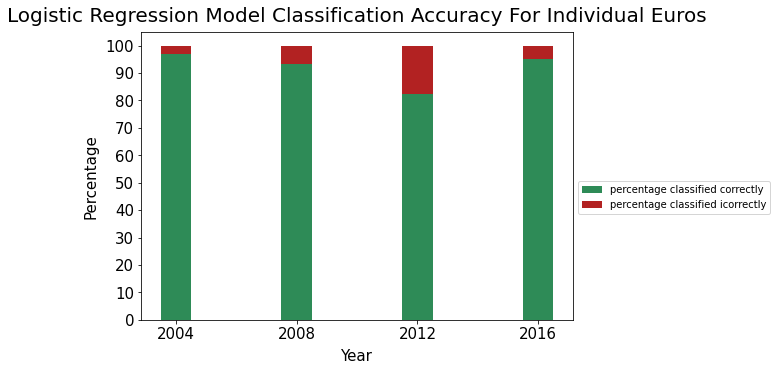

In [61]:
years_lst = [] # this will hold the years from which we have data
percentage_classified_correctly = [] # this will hold the correspond percentage of classification accuracy by our model for the respective year
percentage_classified_incorrectly = []
# Iterating over all the years we had data for and finding the percentage of classifications that were correct and
# incorrect
for year in range(2004, 2017, 4):
    total_count = 0
    correct_classification_counts = 0
    for index, row in model_df.loc[model_df['year'] == year].iterrows():
        player_gpm = float(row['Player_GPM'])
        team_gpm = float(row['Team_GPM'])
        player_gp = float(row['Player_GP'])
        team_elo = float(row['Team_ELO'])
        inv_group_elo = float(row['Inv_Group_ELO'])
        actual_classification = row['Scored_In_Group_Stage']
        predicted_classification = model.predict([[player_gpm,team_gpm,player_gp,team_elo,inv_group_elo]])
        predicted_classification_extracted = predicted_classification[0]
        if actual_classification == predicted_classification_extracted:
            correct_classification_counts = correct_classification_counts + 1
        total_count = total_count + 1
    percentage_correct = (correct_classification_counts / total_count) * 100
    percentage_incorrect = 100 - percentage_correct
    percentage_classified_correctly.append(percentage_correct)
    percentage_classified_incorrectly.append(percentage_incorrect)
    years_lst.append(year)
    
# Creating bar plot displaying how well our model did for each of the Euros we had data for
ind = years_lst
width = 0.40
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, percentage_classified_correctly, width=1, color='seagreen')
ax.bar(ind, percentage_classified_incorrectly, width=1 ,bottom=percentage_classified_correctly, color='firebrick')
ax.set_ylabel('Percentage', labelpad=7, fontsize=15)
ax.set_xlabel('Year', labelpad=7, fontsize=15)
ax.set_title('Logistic Regression Model Classification Accuracy For Individual Euros', pad=10, fontsize=20)
ax.set_xticks(ind)
ax.set_yticks(np.arange(0, 101, 10))
ax.tick_params(labelsize=15)
ax.legend(labels=['percentage classified correctly', 'percentage classified icorrectly'], bbox_to_anchor=(1, 0.5))
plt.show()

<p style="font-size:16px">
Looking at our plot, it looks like our model does a uniform job in regards to classification accuracy across the years of data we have. There is a slight dip in the year 2012, but even in that year, the model was still able to classify over 80% of the data points correctly. Since we are satisfied with the performance of our model, let's move on to using this model to predict classifications for the Euros this year...
</p>

<h1 style="font-size:18px">
Predicting Goalscorers For This Year
</h1>

<p style="font-size:16px">
In order to do this, we must first get all the qualifying data from this years Euros, derive all the input features needed for our model, and storing it all in a dataframe (like we had done for the years previous).
</p>

In [62]:
# Creating function that will return the dataframe with Euro 2020/2021 qualifying data, with rows containing all the
# input features required for our dataframe.
def modifyPredDf(year, pred_df, qualifying_teams_df, qualifying_goalscorers_df, teams, group_lst):
    # Calculating ratings for teams based on matches played against each other in the year leading up to the tournament
    year_as_int = int(year)
    year_before = year_as_int - 1
    ratings = calculate_elo(teams, [year_before,year_as_int]) 
    # Processing each goalscorer and deriving the additional values necessary to add a new row to our model_df 
    for index, row in qualifying_goalscorers_df.iterrows():
        name = row['Player']
        team = row['Team']
        player_gs = row['Goals_Scored']
        team_row = qualifying_teams_df.loc[qualifying_teams_df['Team'] == team]
        pld = team_row['Pld'].values
        player_gpm = float(player_gs) / float(pld[0])
        team_gpm = float(team_row['GF']) / float(team_row['Pld'])
        player_gp = float(row['Goals_Scored']) / float(team_row['GF'])*100
        date = str(year)+'-01-01'  # Date we will use to get ELO ratings
        team_elo = ratings.loc[date][team]
        group_elo_sum = 0
        # Calculating group ELO ranking sum by going through other teams in the group and adding their ELO ranking
        # from the past year to the sum
        for group in group_lst:
            if team in group:
                for other_team in group:
                    if other_team != team:
                        group_elo_sum += ratings.loc[date][other_team]
        inv_group_elo = 1/group_elo_sum
        # Adding player row to our dataframe
        pred_df = pred_df.append(pd.DataFrame([[year,name,team,player_gpm,team_gpm,player_gp,team_elo,inv_group_elo]], columns=pred_df.columns)) 

    return pred_df

In [63]:
# Here's the list of teams that qualified for the Euros this year
teams = ['Turkey', 'Italy', 'Wales', 'Switzerland',
         'Denmark', 'Finland', 'Belgium', 'Russia',
         'Netherlands', 'Ukraine', 'Austria', 'North Macedonia',
         'England', 'Croatia', 'Scotland', 'Czech Republic',
         'Spain', 'Sweden', 'Poland', 'Slovakia',
         'Hungary', 'Portugal', 'France', 'Germany']
groups_lst = [] # we will populate this list with elements which are lists themselves, each list containing teams from a group
teams_in_group_count = 0
curr_group = [] # will hold all the teams in the current group.
# Here we are iterating over all the teams and populating our groups_lst
for team in teams:
    teams_in_group_count = teams_in_group_count + 1
    curr_group.append(team)
    if teams_in_group_count == 4: # there are only 4 teams in a group, so we can add group to our masterlist and move on to processing the next group
        groups_lst.append(curr_group)
        curr_group = []
        teams_in_group_count = 0
qualifying_teams_df = getQualifiedTeamsDf('2020', teams)
qualifying_goalscorers_df = getQualifyingGoalScorersDf('2020', 12, teams)
# Creating data frame for 2020 Euros having rows for each of the goalscorers during Euro 2020 qualifying.
# For now we will add columns for the player name, team, player goals per match, team goals per match, 
# player goal percentage, team ELO ranking, and inverse group ELO ranking, and based on these values, we will
# use our predictive model that we just generated to fill in the value of the 'predicted' column, which will hold
# our prediction of whether the player will score at least one goal in this year's Euros or not
pred_df = pd.DataFrame(columns = ['year','Player_Name','Team','Player_GPM','Team_GPM','Player_GP','Team_ELO','Inv_Group_ELO'])
pred_df = modifyPredDf(year, pred_df, qualifying_teams_df, qualifying_goalscorers_df, teams, groups_lst)
pred_df = pred_df.reset_index(drop=True)
pred_df.head()

,year,Player_Name,Team,Player_GPM,Team_GPM,Player_GP,Team_ELO,Inv_Group_ELO
0,2016,Harry Kane,England,1.500,4.625,32.432432,1212.782207,0.000279
1,2016,Cristiano Ronaldo,Portugal,1.375,2.750,50.000000,1198.959462,0.000275
2,2016,Teemu Pukki,Finland,1.000,1.600,62.500000,1199.645494,0.000280
3,2016,Artem Dzyuba,Russia,0.900,3.300,27.272727,1199.966789,0.000280
4,2016,Raheem Sterling,England,1.000,4.625,21.621622,1212.782207,0.000279


<p style="font-size:16px">
Great, now that we've got all the input features in a dataframe, we can iterate over each of the rows and predict, for each player, whether they will score a goal in the group stages of the Euros or not, adding it as an additional column to our dataframe...
</p>

In [64]:
# Here we are adding an additional column to our dataframe, which we will populate with the values that our model produces.
pred_df['Predicted_To_Score_Goal_In_GS'] = False
# Iterating over all the rows of players and using our model to predict/classify whether the player will score in
# group stage or not, then inserting the result in the value of the column 'Predicted_To_Score_In_Gs' 
for index, row in pred_df.iterrows():
    player_gpm = float(row['Player_GPM'])
    team_gpm = float(row['Team_GPM'])
    player_gp = float(row['Player_GP'])
    team_elo = float(row['Team_ELO'])
    inv_group_elo = float(row['Inv_Group_ELO'])
    predicted_classification = model.predict([[player_gpm,team_gpm,player_gp,team_elo,inv_group_elo]])
    predicted_classification_extracted = predicted_classification[0]
    pred_df.at[index,'Predicted_To_Score_Goal_In_GS'] = predicted_classification_extracted
    
pred_df.head()

,year,Player_Name,Team,Player_GPM,Team_GPM,Player_GP,Team_ELO,Inv_Group_ELO,Predicted_To_Score_Goal_In_GS
0,2016,Harry Kane,England,1.500,4.625,32.432432,1212.782207,0.000279,True
1,2016,Cristiano Ronaldo,Portugal,1.375,2.750,50.000000,1198.959462,0.000275,True
2,2016,Teemu Pukki,Finland,1.000,1.600,62.500000,1199.645494,0.000280,True
3,2016,Artem Dzyuba,Russia,0.900,3.300,27.272727,1199.966789,0.000280,False
4,2016,Raheem Sterling,England,1.000,4.625,21.621622,1212.782207,0.000279,False


<p style="font-size:16px">
Now that we've have populated the column with the predictions for each player, let's go ahead and take a look at which players were predicted to score...
</p>

In [65]:
pred_df.loc[pred_df['Predicted_To_Score_Goal_In_GS'] == True]

,year,Player_Name,Team,Player_GPM,Team_GPM,Player_GP,Team_ELO,Inv_Group_ELO,Predicted_To_Score_Goal_In_GS
0,2016,Harry Kane,England,1.500,4.625,32.432432,1212.782207,0.000279,True
1,2016,Cristiano Ronaldo,Portugal,1.375,2.750,50.000000,1198.959462,0.000275,True
2,2016,Teemu Pukki,Finland,1.000,1.600,62.500000,1199.645494,0.000280,True


<h1 style="font-size:18px">
The Results
</h1>
<p style="font-size:16px">
Based on our analysis, we have predicted the following players to score at least 1 goal during the UEFA European Championship Group Stages...
</p>

<h1 style="font-size:16px">
1) Harry Kane
</h1>
<h1 style="font-size:16px">
2) Cristiano Ronaldo
</h1>
<h1 style="font-size:16px">
3) Teemu Pukki
</h1>

<p style="font-size:16px">
As these players have been predicted by our model to score at least 1 goal during the group stages, we make the case that these three players should be the foundation of your fantasy team, and you can build the rest of your team around these players (unless you don't like watching your fantasy assets scoring goals and racking up the points, just kidding).
</p>

<p style="font-size:16px">
Of course, it goes without mentioning that these are just predictions, and are not indicative of whether a player is "guaranteed" to score. That being said, we believe in our model (and its accuracy to a certain extent based on the tests we ran previously) and therefore are backing these players to bring home the gold for you!
</p>

---

<h1 align="center">
    Conclusion
</h1>

<p style="font-size:16px">
    From our hypothesis test we decided that home team advantage does not really effect win rate. Because of this we did not factor in home team advantage to our elo system, which was the backbone of all our results. Through a simulation using elo and probability we have predicted that Portugal will win the 2020 Euros. The Euros take place from June 11, 2021 to July 11, 2021 so feel free to see whether we predicted the results correctly!
</p>

<p style="font-size:16px">
    Using data from past Euros we were also able to predict which players would score in the group stage as this would help when deciding which players to pick. Our top 2 were Harry Kane and Cristiano Ronaldo, two of the best players in the world at the moment. Our third pick was a Finnish player many people do not know, Teemu Pukki. If you are wondering why Lionel Messi and other predominant players were nowhere to be found in the datasets, that is because these players do not play for a European team and therefore will not feature in the Euros.
</p>

<p style="font-size:16px">
    In our two sections (Predicting The Tournament Winner and The Search For Fantasy Gold), we utilized two different methods in order to gather and store our data in a pandas dataframe. In Section 1, we showed you how to read a csv file into a pandas dataframe, and in Section 2, we used BeautifulSoup to scrape the data needed. The two approaches yielded a similar process in regards to the structure of the pipeline, but a major difference is the amount of time spent in each phase of the pipeline. Specifically, in Section 1, having the data initially in a csv file allowed us to easily and quickly get our data into the format desired (a pandas dataframe). This led to us spending minimal time on the data accessing, management, and representation, and enabled us to spend the bulk of our time in the other phases of the data science pipeline (exploratory data analysis, hypothesis testing, etc.). On the other hand, Section 2 required a signficant amount of time to scrape the data from the various pages of html and get it into the ultimate pandas dataframe used during our exploration and analysis. This led to analysis itself requiring proportionally less time, with tools such as Scikit Learn enabling us to quickly create a predictive model to find the "best" fantasy assets.
</p>

<p style="font-size:16px">
    As you can see, there are benefits and drawbacks of each approach. When using csv files (or any another sort of readily formatted and accessible data), the data management and representation phase requires significantly less time, allowing you the opportunity to dedicate your energy and efforts into the exploration and analysis portions. The drawback is that you are only limited to the pre-made datasets that you can find on the internet, which can prevent you from doing analysis using specific metrics or statistics (which may be extremely valuable). On other hand, scraping html gives you that wider range of data, as sort of table, list, or even regular text becomes fair game. You now have the ability to acquire those metrics and statistics that you may not have had access too before. The obvious, and perhaps painstaking, drawback (as we personally experienced ourselves) is that scraping html on "messy" website is highly time and energy consuming. This will lead to you having significantly less time for actual analysis (especially when you have to conduct analysis within a specific time frame). Given these pros and cons, our recommendation is to go for readily accessible data (such as csv files) when you can. Especially if you can find a dataset with all the information you are looking for to conduct your analysis, utilizing those available datasets is likely the best option. In the few instances where you have scoured the internet for every possible dataset and couldn't find the data you were looking for (and the only place it happens to be on is Wikipedia), then there likely is no other option than going down the rabbit hole that is BeautifulSoup and web scraping. 
</p>

<p style="font-size:16px">
    Hopefully after seeing this tutorial you have learned different techniques on how to leverage data from all over the internet to make something new and get the results that you are looking for. And maybe this will be motivation for all non-soccer fans to go out and watch some of the Euros! 
</p>